In [1]:
## install git and configure(so we know who commit the code)
# !apt-get install git
# !git config --global user.name "USER_NAME"
# !git config --global user.email "EMAIL"

# access google drive
# from google.colab import drive
# drive.mount('/content/drive')

# clone repo
!git clone https://github.com/Mu-niu13/Image-Translation-CycleGAN.git
%cd Image-Translation-CycleGAN

# set up personal access for push/pull
from getpass import getpass
token = getpass('Enter your GitHub PAT:')
!git remote set-url origin https://{token}@github.com/Mu-niu13/Image-Translation-CycleGAN.git

Cloning into 'Image-Translation-CycleGAN'...
remote: Enumerating objects: 1232, done.
remote: Counting objects: 100% (1232/1232), done.
remote: Compressing objects: 100% (1226/1226), done.
remote: Total 1232 (delta 9), reused 1215 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (1232/1232), 36.21 MiB | 9.45 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/Image-Translation-CycleGAN
Enter your GitHub PAT:··········


In [11]:
!pip install torch_fidelity

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics
from tqdm import tqdm
from scipy.linalg import sqrtm

In [ ]:
def save_images_to_dir(images, directory):
    """Save a batch of images to the specified directory."""
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        img_path = os.path.join(directory, f"image_{i}.png")
        img = (img * 0.5 + 0.5).clamp(0, 1)  # Denormalize
        save_image(img, img_path)

def calculate_fid_and_inception(real_images, generated_images):
    """Calculate FID and Inception Score."""
    real_dir = "./temp/real_monet_images"
    fake_dir = "./temp/generated_images"

    # Save images to directories
    save_images_to_dir(real_images, real_dir)
    save_images_to_dir(generated_images, fake_dir)

    # Calculate metrics with reduced verbosity
    metrics = calculate_metrics(
        input1=real_dir,
        input2=fake_dir,
        cuda=torch.cuda.is_available(),  # Use GPU if available
        isc=True,  # Calculate Inception Score
        fid=True,  # Calculate FID
        verbose=False  # Disable verbose logging
    )

    # Clean up temporary directories
    shutil.rmtree(real_dir)
    shutil.rmtree(fake_dir)

    return metrics

In [ ]:
###############################################
# Dataset Classes
###############################################

class MonetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(os.path.join(root, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

###############################################
# CycleGAN Networks
###############################################

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64):
        super(Generator, self).__init__()
        # Initial Convolutional Block
        self.initial = nn.Sequential(
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        )

        # Downsampling Layers
        self.down1 = nn.Sequential(
            nn.Conv2d(ngf, ngf * 2, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf * 2),
            nn.ReLU(inplace=True)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True)
        )

        # Residual Blocks (Explicitly Defined)
        self.residual1 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )
        self.residual2 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )
        self.residual3 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )
        self.residual4 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )
        self.residual5 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )
        self.residual6 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(ngf * 4)
        )

        # Upsampling Layers
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf * 2),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        )

        # Final Layer
        self.final = nn.Sequential(
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)

        # Apply Residual Blocks
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = x + self.residual3(x)
        x = x + self.residual4(x)
        x = x + self.residual5(x)
        x = x + self.residual6(x)

        x = self.up1(x)
        x = self.up2(x)
        x = self.final(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
###############################################
# Loss Functions
###############################################

def cycle_consistency_loss(x, reconstructed_x, lambda_cycle=10.0):
    """Cycle consistency loss to ensure translation is invertible."""
    return lambda_cycle * torch.mean(torch.abs(x - reconstructed_x))

def identity_loss(x, identity_x, lambda_identity=5.0):
    """Identity loss to ensure color and texture consistency."""
    return lambda_identity * torch.mean(torch.abs(x - identity_x))

def gan_loss(pred, target_is_real=True):
    """Adversarial loss to distinguish between real and fake images."""
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return torch.mean((pred - target)**2)

=== Training at resolution 32x32 ===
Files already downloaded and verified


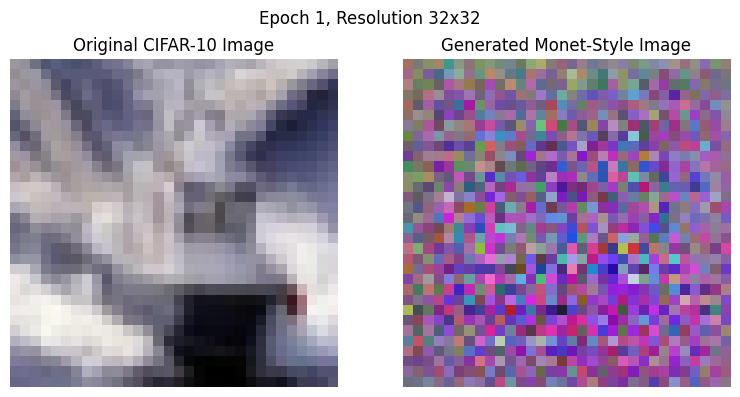

Epoch 1/15 | G Loss: 0.2511 | D Loss: 0.0162


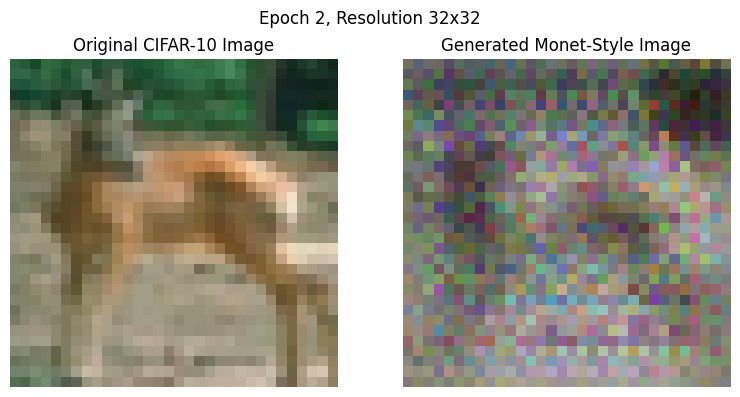

Epoch 2/15 | G Loss: 0.2142 | D Loss: 0.0110


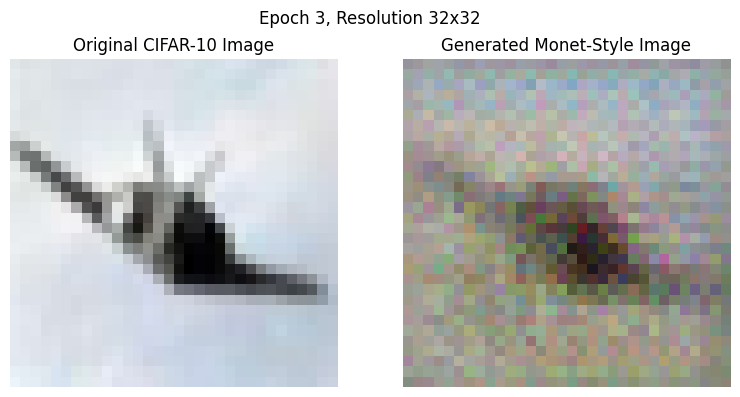

Epoch 3/15 | G Loss: 0.1885 | D Loss: 0.0111


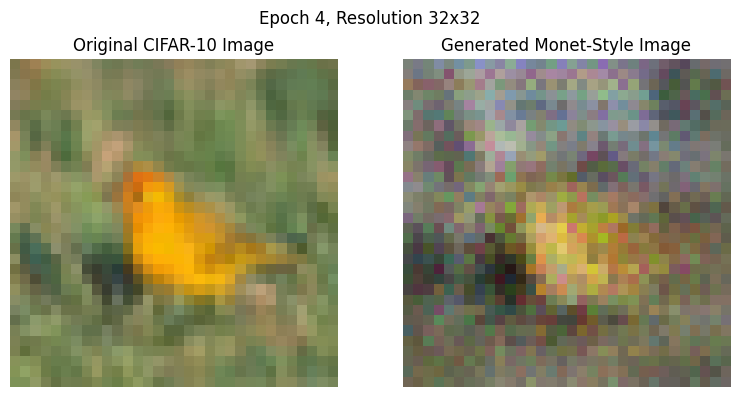

Epoch 4/15 | G Loss: 0.1724 | D Loss: 0.0109


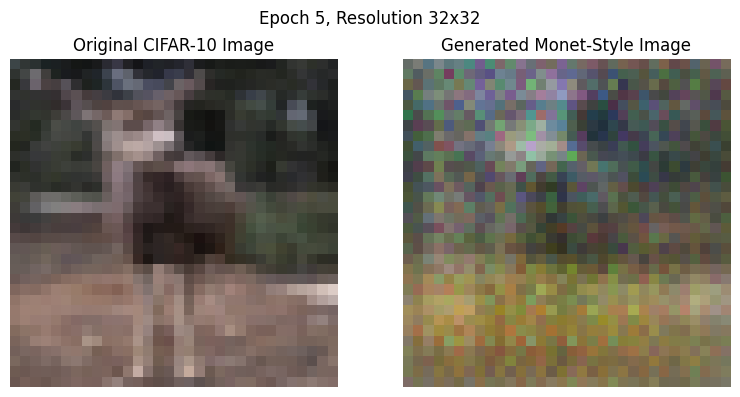

Epoch 5/15 | G Loss: 0.1595 | D Loss: 0.0111


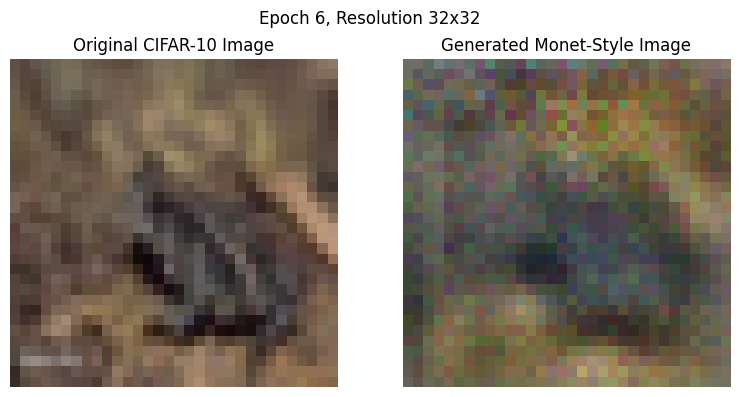

Epoch 6/15 | G Loss: 0.1531 | D Loss: 0.0107


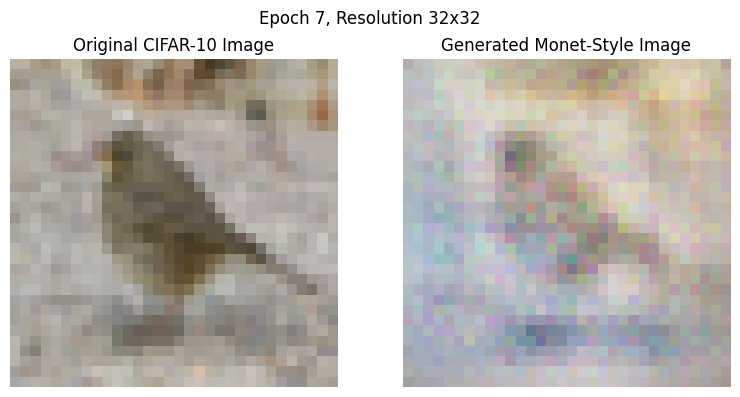

Epoch 7/15 | G Loss: 0.1497 | D Loss: 0.0106


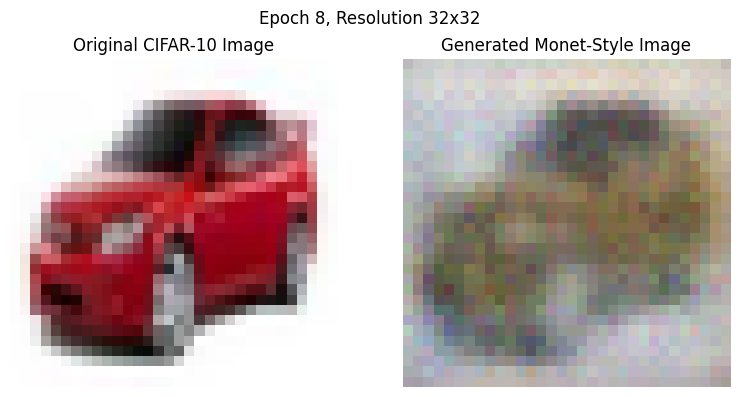

Epoch 8/15 | G Loss: 0.1481 | D Loss: 0.0104


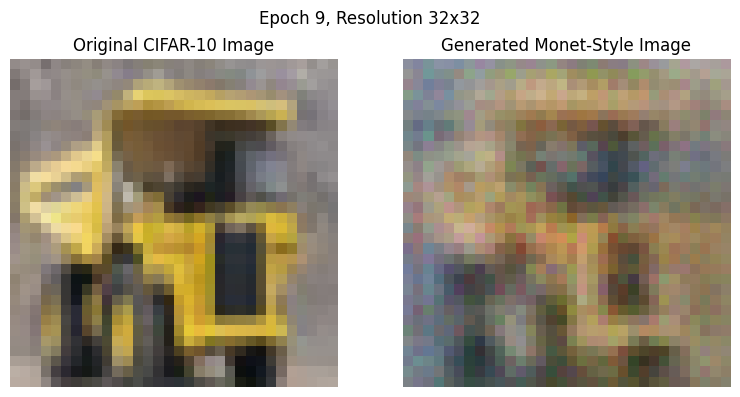

Epoch 9/15 | G Loss: 0.1454 | D Loss: 0.0100


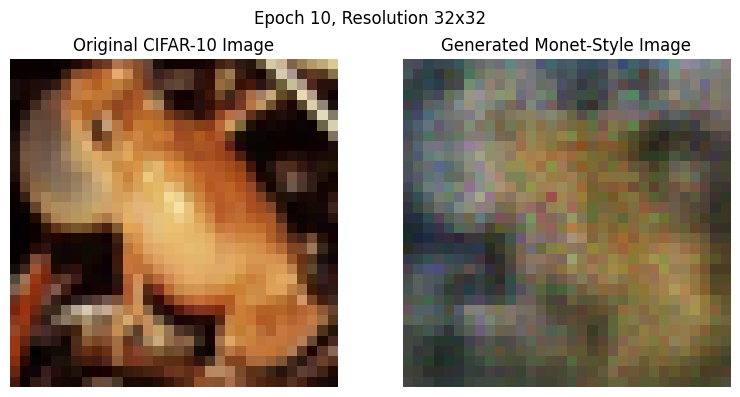

Epoch 10/15 | G Loss: 0.1451 | D Loss: 0.0100


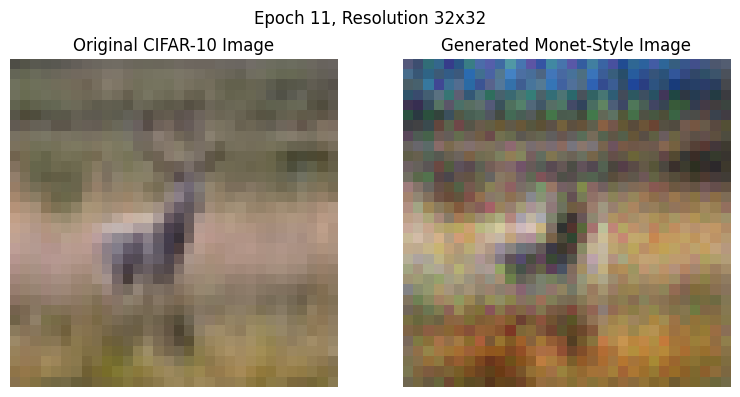

Epoch 11/15 | G Loss: 0.1404 | D Loss: 0.0098


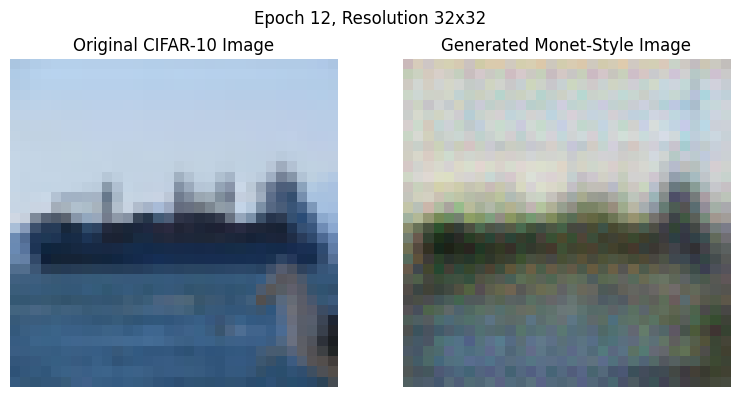

Epoch 12/15 | G Loss: 0.1402 | D Loss: 0.0099


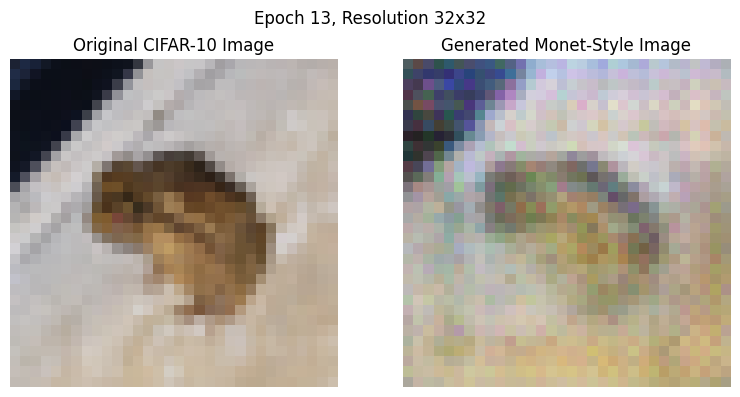

Epoch 13/15 | G Loss: 0.1371 | D Loss: 0.0098


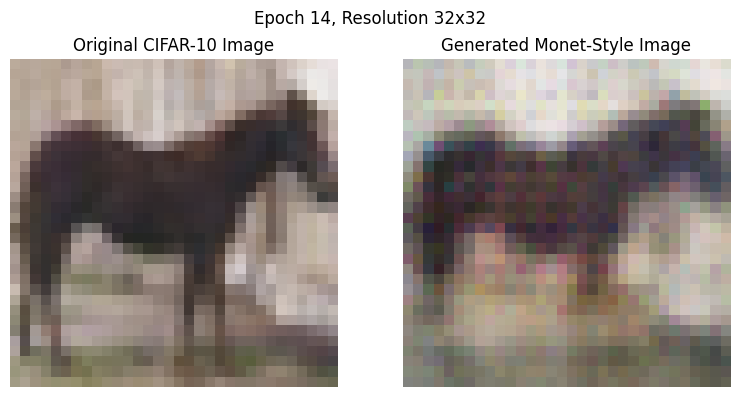

Epoch 14/15 | G Loss: 0.1345 | D Loss: 0.0098


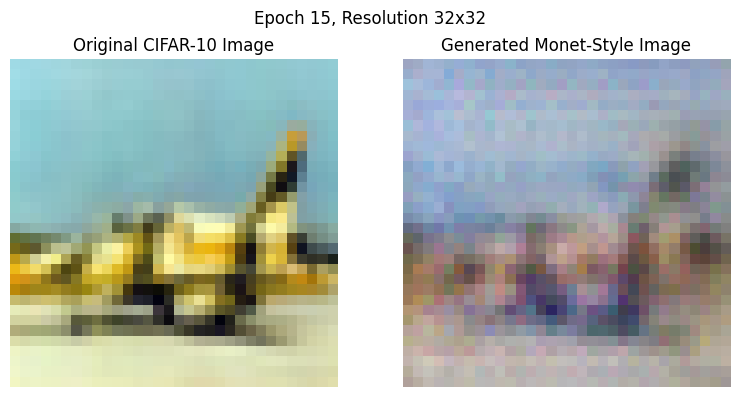

Epoch 15/15 | G Loss: 0.1311 | D Loss: 0.0098
Metrics at Resolution 32x32:
FID: 305.9651
Inception Score: 1.8240
=== Training at resolution 64x64 ===
Files already downloaded and verified


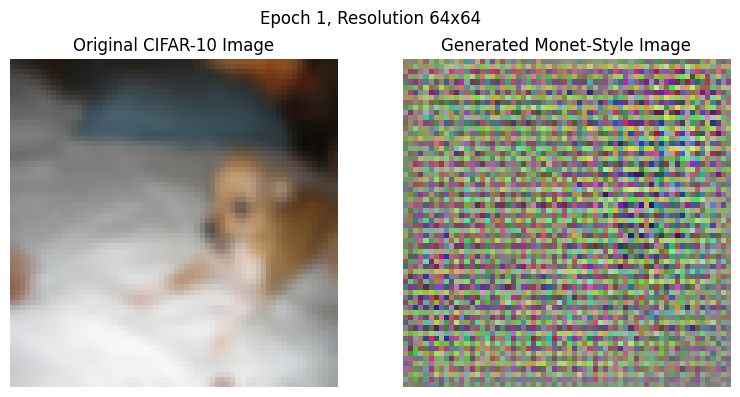

Epoch 1/15 | G Loss: 0.2267 | D Loss: 0.0136


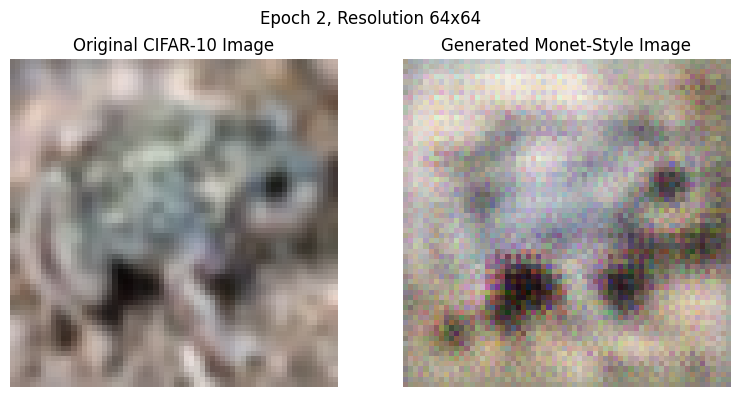

Epoch 2/15 | G Loss: 0.1853 | D Loss: 0.0107


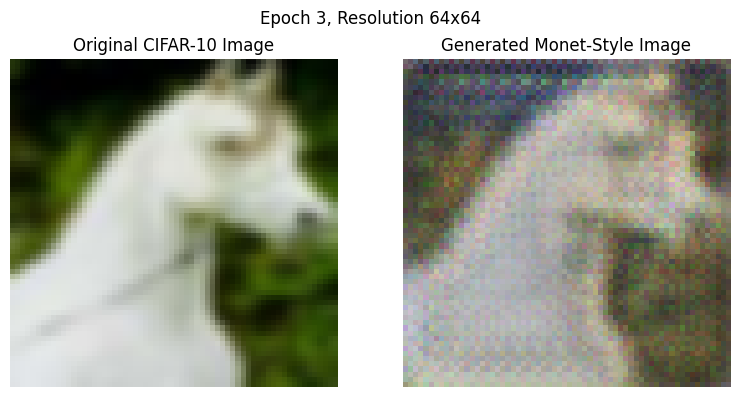

Epoch 3/15 | G Loss: 0.1742 | D Loss: 0.0109


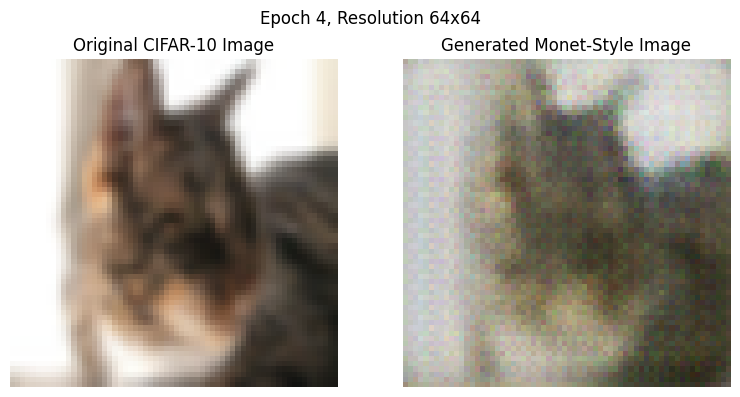

Epoch 4/15 | G Loss: 0.1560 | D Loss: 0.0109


Epoch 5/15 | G Loss: 0.1453 | D Loss: 0.0106


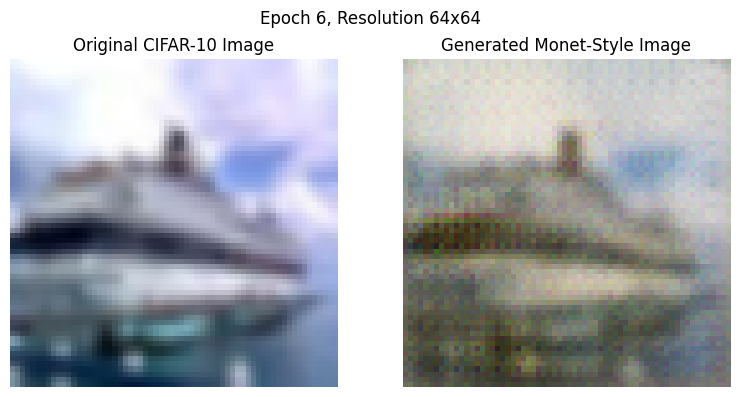

Epoch 6/15 | G Loss: 0.1388 | D Loss: 0.0104


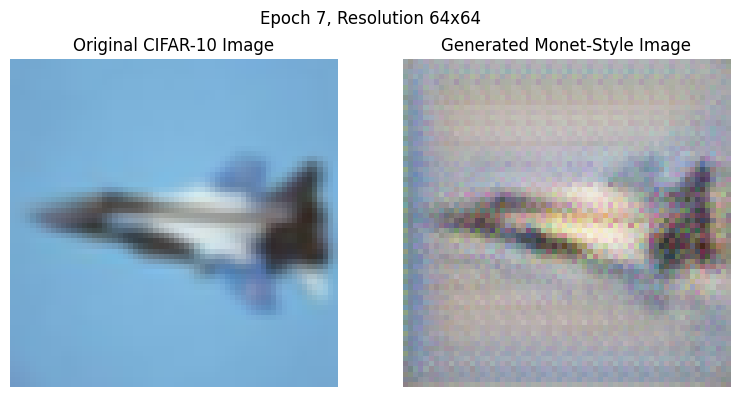

Epoch 7/15 | G Loss: 0.1381 | D Loss: 0.0103


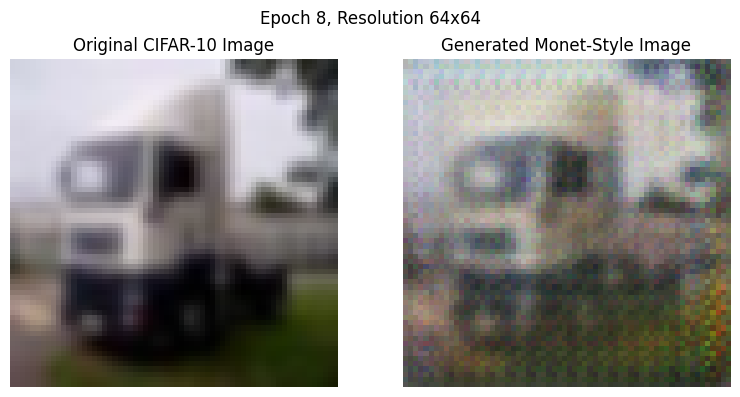

Epoch 8/15 | G Loss: 0.1318 | D Loss: 0.0100


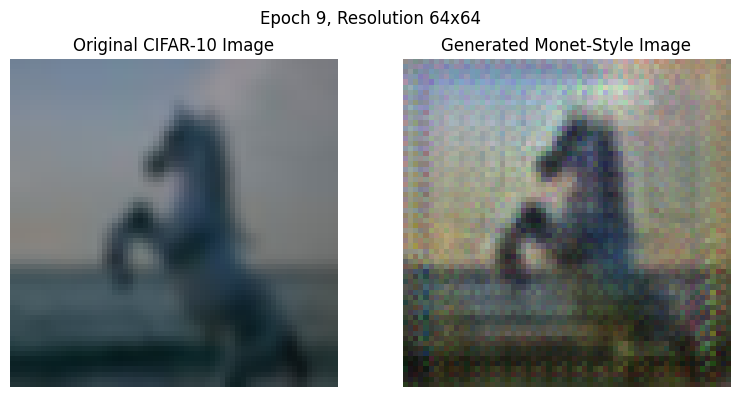

Epoch 9/15 | G Loss: 0.1299 | D Loss: 0.0099


Epoch 10/15 | G Loss: 0.1299 | D Loss: 0.0099


Epoch 11/15 | G Loss: 0.1263 | D Loss: 0.0097


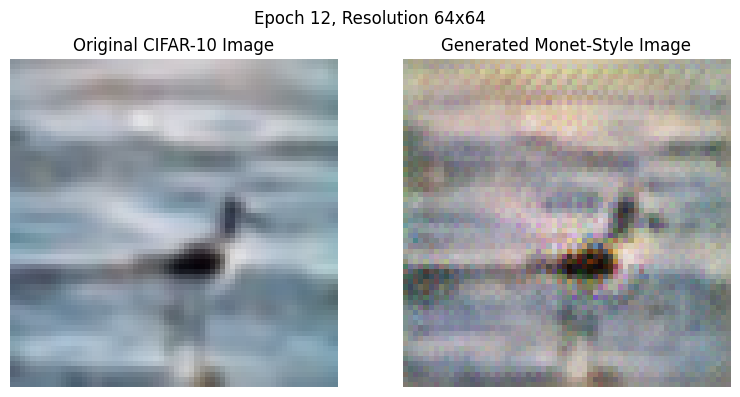

Epoch 12/15 | G Loss: 0.1273 | D Loss: 0.0097


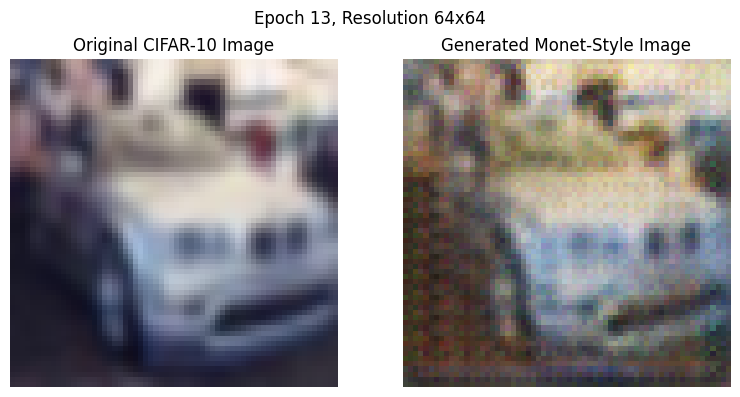

Epoch 13/15 | G Loss: 0.1244 | D Loss: 0.0097


Epoch 14/15 | G Loss: 0.1231 | D Loss: 0.0098


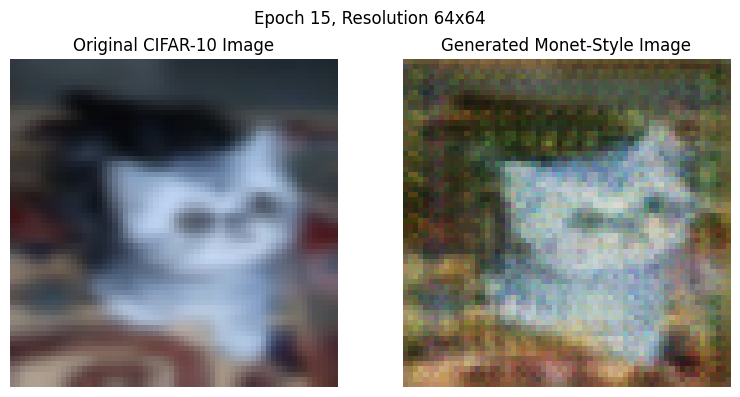

Epoch 15/15 | G Loss: 0.1200 | D Loss: 0.0096
Metrics at Resolution 64x64:
FID: 284.6642
Inception Score: 1.8389
=== Training at resolution 128x128 ===
Files already downloaded and verified


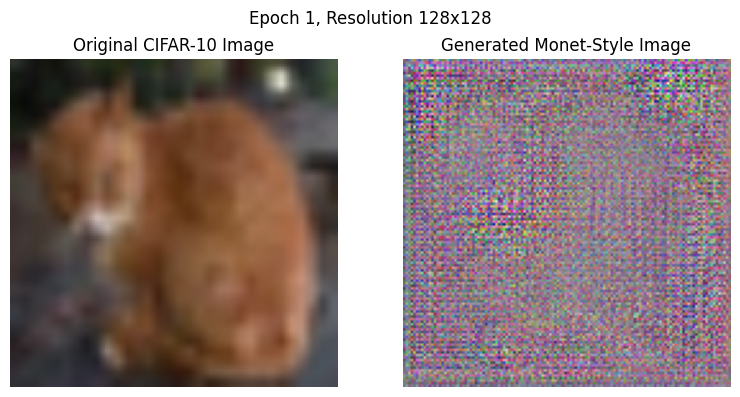

Epoch 1/15 | G Loss: 0.2158 | D Loss: 0.0146


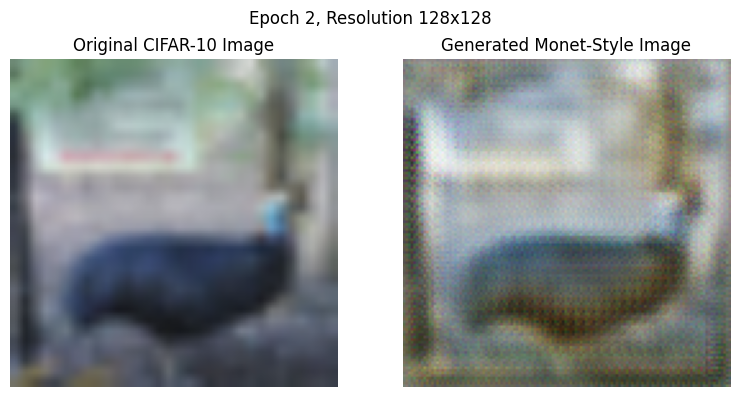

Epoch 2/15 | G Loss: 0.1879 | D Loss: 0.0109


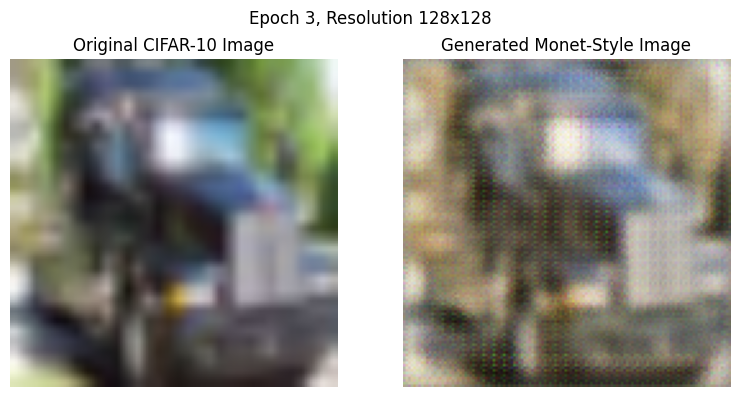

Epoch 3/15 | G Loss: 0.1715 | D Loss: 0.0107


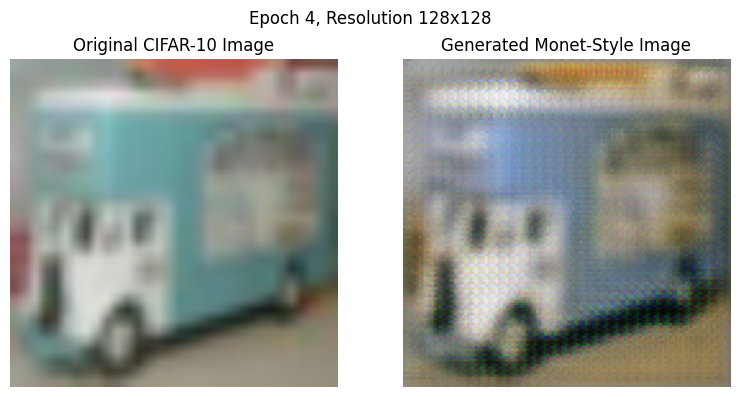

Epoch 4/15 | G Loss: 0.1608 | D Loss: 0.0106


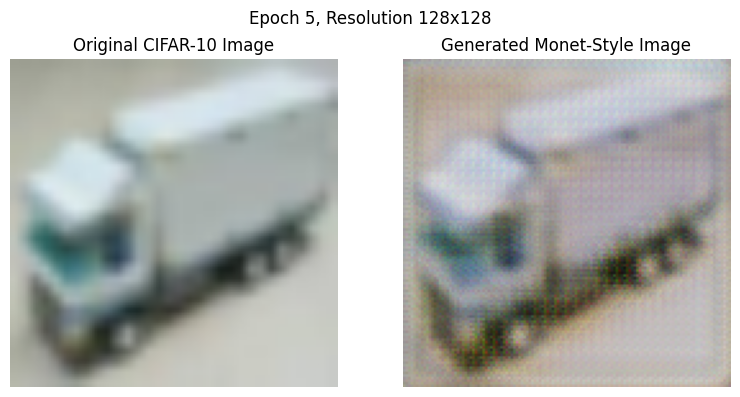

Epoch 5/15 | G Loss: 0.1493 | D Loss: 0.0105


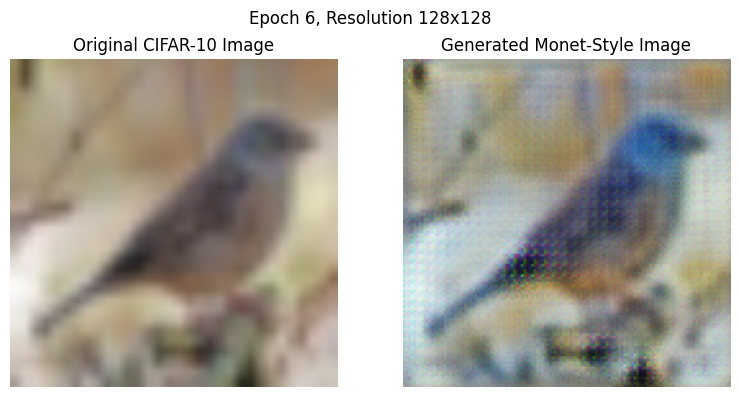

Epoch 6/15 | G Loss: 0.1415 | D Loss: 0.0103


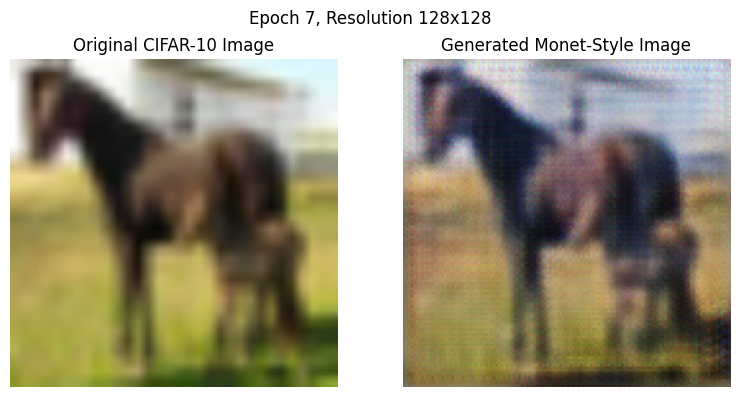

Epoch 7/15 | G Loss: 0.1386 | D Loss: 0.0102


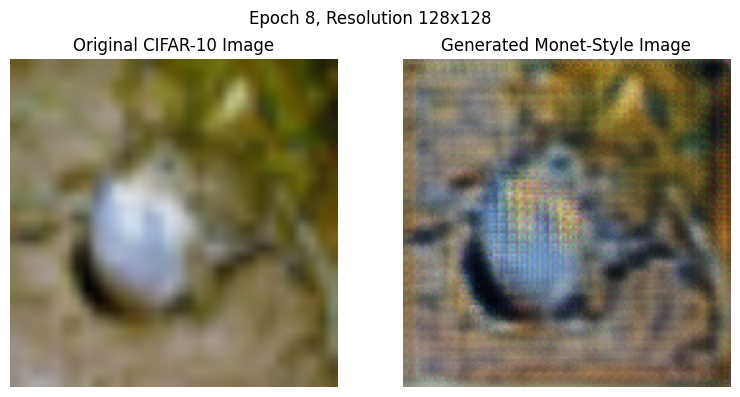

Epoch 8/15 | G Loss: 0.1360 | D Loss: 0.0097


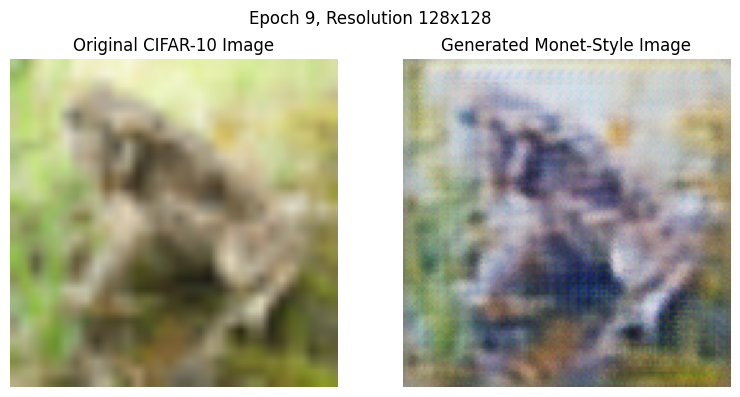

Epoch 9/15 | G Loss: 0.1331 | D Loss: 0.0090


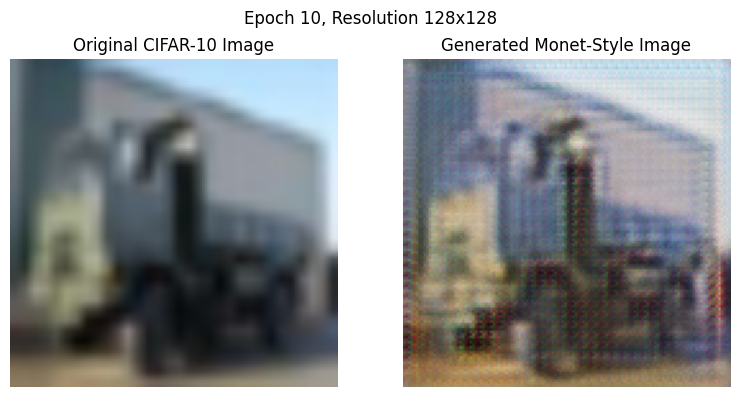

Epoch 10/15 | G Loss: 0.1333 | D Loss: 0.0088


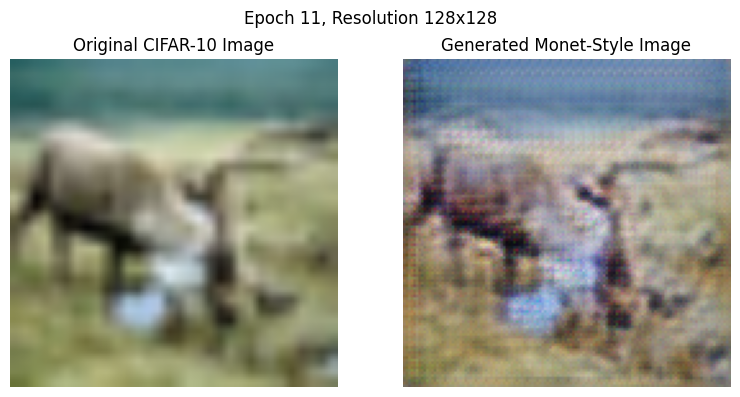

Epoch 11/15 | G Loss: 0.1355 | D Loss: 0.0086


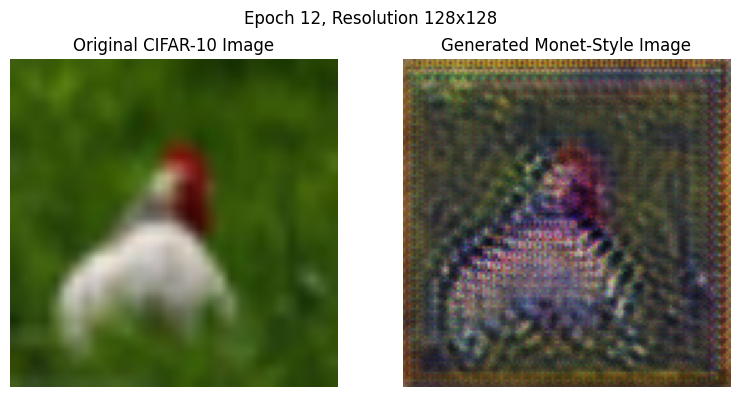

Epoch 12/15 | G Loss: 0.1315 | D Loss: 0.0081


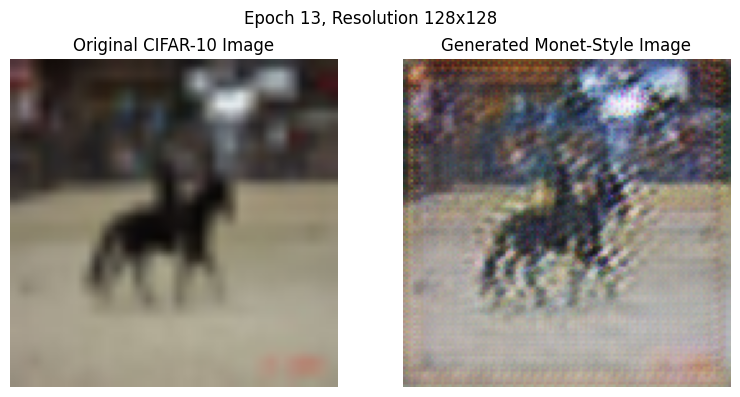

Epoch 13/15 | G Loss: 0.1319 | D Loss: 0.0084


Epoch 14/15 | G Loss: 0.1310 | D Loss: 0.0079


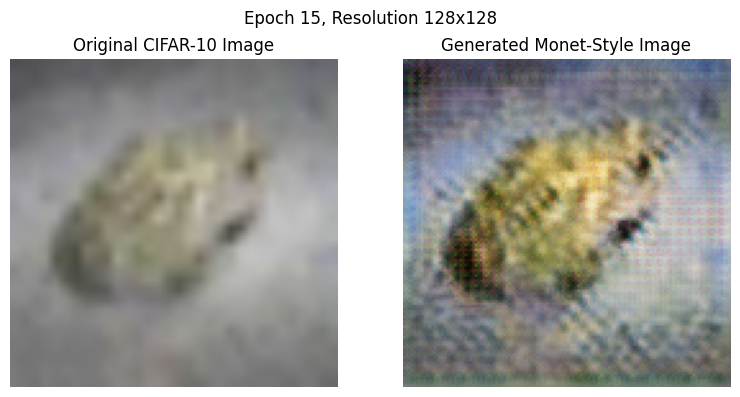

Epoch 15/15 | G Loss: 0.1295 | D Loss: 0.0088
Metrics at Resolution 128x128:
FID: 379.9929
Inception Score: 1.9553
=== Training at resolution 256x256 ===
Files already downloaded and verified


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 327.06 MiB is free. Process 12101 has 14.43 GiB memory in use. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 2.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
###############################################
# Main Training Loop
###############################################

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    resolutions = [16, 32, 64, 128, 256, 512, 1024]
    epochs_per_stage = 10
    batch_size = 32
    lr = 0.0002
    beta1, beta2 = 0.5, 0.999

    lambda_cycle = 10
    lambda_identity = 5


    for resolution in resolutions:
        print(f"=== Training at resolution {resolution}x{resolution} ===")
        transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # Load CIFAR-10 and Monet datasets
        cifar_dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True, transform=transform)
        monet_dataset = MonetDataset(root='./data/monet', transform=transform)

        cifar_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
        monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


        # Initialize models
        G_AtoB = Generator(3, 3).to(device)
        G_BtoA = Generator(3, 3).to(device)
        D_A = Discriminator(3).to(device)
        D_B = Discriminator(3).to(device)

        # Optimizers
        optim_G = optim.Adam(list(G_AtoB.parameters()) + list(G_BtoA.parameters()), lr=lr, betas=(beta1, beta2))
        optim_D = optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=lr, betas=(beta1, beta2))

        # We'll iterate over both datasets in parallel
        # Note: zip stops at the shortest iterator, ensure both have the same length or handle accordingly
        for epoch in range(epochs_per_stage):
            G_AtoB.train()
            G_BtoA.train()
            D_A.train()
            D_B.train()

            epoch_loss_G = 0.0
            epoch_loss_D = 0.0

            for i, ((cifar_images, _), monet_images) in enumerate(zip(cifar_loader, monet_loader)):
                cifar_images = cifar_images.to(device)
                monet_images = monet_images.to(device)

                # Step 1: Train Generators
                optim_G.zero_grad()

                # A->B->A cycle
                fake_monet = G_AtoB(cifar_images)      # CIFAR to Monet
                cycle_cifar = G_BtoA(fake_monet)       # Monet back to CIFAR

                # B->A->B cycle
                fake_cifar = G_BtoA(monet_images)      # Monet to CIFAR
                cycle_monet = G_AtoB(fake_cifar)       # CIFAR back to Monet

                # Identity passes (to encourage generators to not change images of the target domain)
                identity_monet = G_AtoB(monet_images)  # Monet image through AtoB (should remain Monet)
                identity_cifar = G_BtoA(cifar_images)   # CIFAR image through BtoA (should remain CIFAR)

                # Compute Generator Losses
                loss_gan_AtoB = gan_loss(D_B(fake_monet), True)   # fool D_B with fake_monet
                loss_gan_BtoA = gan_loss(D_A(fake_cifar), True)   # fool D_A with fake_cifar

                loss_cycle_A = cycle_consistency_loss(cifar_images, cycle_cifar, lambda_cycle)
                loss_cycle_B = cycle_consistency_loss(monet_images, cycle_monet, lambda_cycle)

                loss_identity_A = identity_loss(monet_images, identity_monet, lambda_identity)
                loss_identity_B = identity_loss(cifar_images, identity_cifar, lambda_identity)

                # Total Generator Loss
                loss_G = (
                    loss_gan_AtoB +
                    loss_gan_BtoA +
                    loss_cycle_A +
                    loss_cycle_B +
                    loss_identity_A +
                    loss_identity_B
                )
                loss_G.backward()
                optim_G.step()

                # Step 2: Train Discriminators
                optim_D.zero_grad()

                # Detach fake images for discriminator training
                fake_cifar_detached = fake_cifar.detach()
                fake_monet_detached = fake_monet.detach()

                # Discriminator A (distinguish real CIFAR from fake CIFAR)
                pred_real_A = D_A(cifar_images)
                pred_fake_A = D_A(fake_cifar_detached)
                loss_D_A = (gan_loss(pred_real_A, True) + gan_loss(pred_fake_A, False)) * 0.5

                loss_D_A.backward(retain_graph=True)

                # Discriminator B (distinguish real Monet from fake Monet)
                pred_real_B = D_B(monet_images)
                pred_fake_B = D_B(fake_monet_detached)
                loss_D_B = (gan_loss(pred_real_B, True) + gan_loss(pred_fake_B, False)) * 0.5

                loss_D_B.backward()

                # Step the optimizer
                optim_D.step()

                # Combine D losses
                loss_D = loss_D_A + loss_D_B

                epoch_loss_G += loss_G.item()
                epoch_loss_D += loss_D.item()

                # Save and Display First Image Pair of the First Batch
                if i == 0:  # Only for the first batch in each epoch
                    def denormalize(img):
                        return img * 0.5 + 0.5

                    original_image = cifar_images[0].detach().cpu()
                    generated_image = fake_monet[0].detach().cpu()

                    original_image = denormalize(original_image).permute(1, 2, 0).numpy()
                    generated_image = denormalize(generated_image).permute(1, 2, 0).numpy()

                    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                    axes[0].imshow(np.clip(original_image, 0, 1))
                    axes[0].set_title('Original CIFAR-10 Image')
                    axes[0].axis('off')

                    axes[1].imshow(np.clip(generated_image, 0, 1))
                    axes[1].set_title('Generated Monet-Style Image')
                    axes[1].axis('off')

                    plt.suptitle(f"Epoch {epoch+1}, Resolution {resolution}x{resolution}")
                    plt.tight_layout()
                    plt.show()

            print(f"Epoch {epoch+1}/{epochs_per_stage} | G Loss: {epoch_loss_G/len(cifar_loader):.4f} | "
                  f"D Loss: {epoch_loss_D/len(cifar_loader):.4f}")

        # Evaluate FID and Inception Score
        real_monet_images = next(iter(monet_loader))[:128]
        fake_monet_images = G_AtoB(next(iter(cifar_loader))[0][:128].to(device)).cpu().detach()

        metrics = calculate_fid_and_inception(real_monet_images, fake_monet_images)
        fid_score = metrics['frechet_inception_distance']
        inception_score = metrics['inception_score_mean']

        print(f"Metrics at Resolution {resolution}x{resolution}:")
        print(f"FID: {fid_score:.4f}")
        print(f"Inception Score: {inception_score:.4f}")